In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy import stats
import numpy as np
from itertools import product
from scipy.stats import mannwhitneyu
import seaborn as sns

data = pd.read_csv("WA_Marketing_Campaign.csv")
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


# Introduction

## Project description

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

## Goal

Evaluate A/B testing results and decide which marketing strategy works the best.

## EDA

### Checking for empty values.

In [2]:
if data.isnull().values.any():
    print("Empty values ")
else:
    print("No empty values")

No empty values


### Checking types of the data.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


### Cheking data for duplicated userid.

In [4]:
duplicates = data[
    data.duplicated(subset=["MarketID", "LocationID", "Promotion", "week"], keep=False)
]

print(duplicates)

Empty DataFrame
Columns: [MarketID, MarketSize, LocationID, AgeOfStore, Promotion, week, SalesInThousands]
Index: []


### Sorting descent by SalesInThousands

In [5]:
sorted = data.sort_values(by="SalesInThousands", ascending=False)
sorted

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
144,3,Large,218,2,1,1,99.65
154,3,Large,220,3,1,3,99.12
111,3,Large,209,1,1,4,97.61
104,3,Large,208,1,3,1,96.48
109,3,Large,209,1,1,2,96.01
...,...,...,...,...,...,...,...
287,6,Medium,507,5,2,4,23.44
19,1,Medium,5,10,2,4,23.35
21,1,Medium,6,10,3,2,22.18
283,6,Medium,506,12,2,4,19.26


### Data describe

In [6]:
data.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


### Cheking for outliers in AgeOfStore

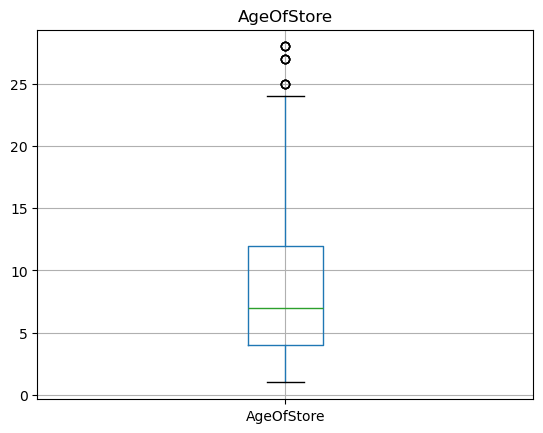

In [7]:
data.boxplot(column="AgeOfStore")
plt.title("AgeOfStore")
plt.show()

### Cheking for outliers in Promotion

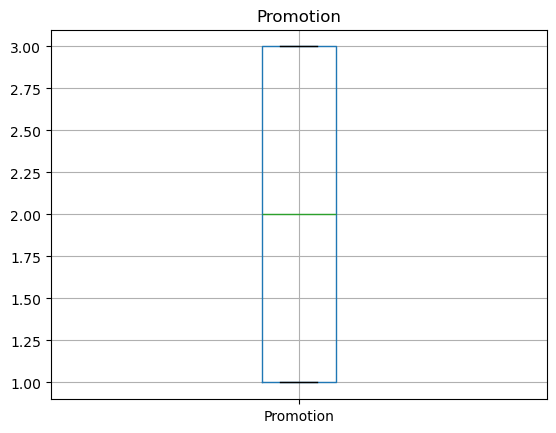

In [8]:
data.boxplot(column="Promotion")
plt.title("Promotion")
plt.show()

### Cheking for outliers in week

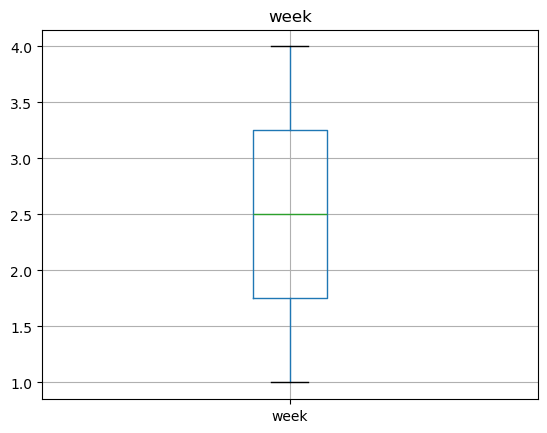

In [9]:
data.boxplot(column="week")
plt.title("week")
plt.show()

### Cheking for outliers in SalesInThousands

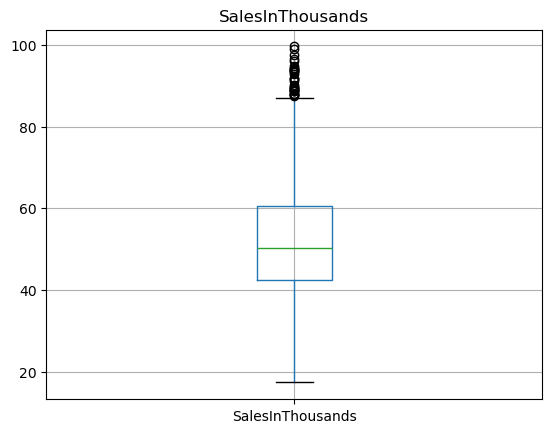

In [10]:
data.boxplot(column="SalesInThousands")
plt.title("SalesInThousands")
plt.show()

### IQR Test

In [11]:
Q1 = data["SalesInThousands"].quantile(0.25)
Q3 = data["SalesInThousands"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[
    (data["SalesInThousands"] < lower_bound) | (data["SalesInThousands"] > upper_bound)
]

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
print("Outliers detected:")
outliers.head()

Q1: 42.545, Q3: 60.4775, IQR: 17.932499999999997
Lower bound: 15.646250000000006, Upper bound: 87.37625
Outliers detected:


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
80,3,Large,202,8,1,1,88.73
83,3,Large,202,8,1,4,94.17
84,3,Large,203,12,3,1,89.70
88,3,Large,204,1,2,1,87.43
90,3,Large,204,1,2,3,88.12


### Cheking for different values in MarketSize

In [12]:
data["MarketSize"].unique()

array(['Medium', 'Small', 'Large'], dtype=object)

### Cheking for different values in MarketID

In [13]:
data["MarketID"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Cheking for different values in LocationID

In [14]:
data["LocationID"].nunique()

137

### Checking for different values in AgeOfStore

In [15]:
data["AgeOfStore"].unique()

array([ 4,  5, 12,  1, 10, 15,  6, 22,  8, 19, 11, 13,  3,  7,  2, 23,  9,
       28, 25, 14, 24, 18, 27, 17, 20])

### Spliting stores ages to intervals

In [16]:
intervals = [0, 5, 10, float("inf")]
name = ["<5", "5-10", ">10"]


data["Age_group"] = pd.cut(data["AgeOfStore"], bins=intervals, labels=name, right=False)

data

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,Age_group
0,1,Medium,1,4,3,1,33.73,<5
1,1,Medium,1,4,3,2,35.67,<5
2,1,Medium,1,4,3,3,29.03,<5
3,1,Medium,1,4,3,4,39.25,<5
4,1,Medium,2,5,2,1,27.81,5-10
...,...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34,<5
544,10,Large,920,14,2,1,50.20,>10
545,10,Large,920,14,2,2,45.75,>10
546,10,Large,920,14,2,3,44.29,>10


# Analysis

### Calculating sum of sales by Promotion

In [17]:
df_grouped = data.groupby("Promotion").agg(
    {"SalesInThousands": ["sum", "mean", "count"]}
)
df_grouped

SalesInThousands                 
                       sum       mean count
Promotion                                  
1                  9993.03  58.099012   172
2                  8897.93  47.329415   188
3                 10408.52  55.364468   188

### Plot for Promotion comarison by sum, mean and count

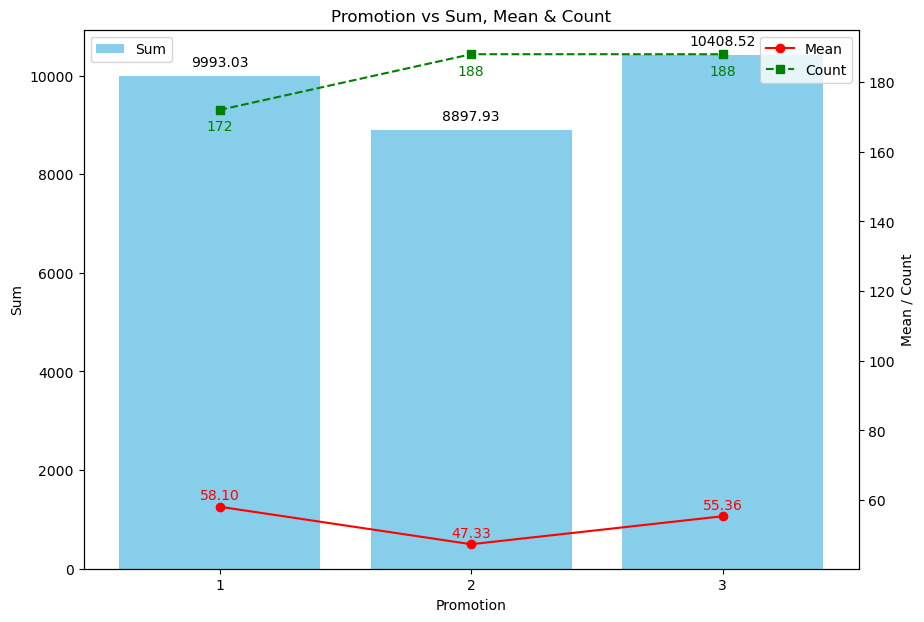

In [18]:
df = df_grouped.copy()
df.columns = df.columns.droplevel(0)
df.reset_index(inplace=True)

df.columns = ["Promotion", "sum", "mean", "count"]

fig, ax1 = plt.subplots(figsize=(10, 7))

bars = ax1.bar(df["Promotion"], df["sum"], color="skyblue", label="Sum")
ax1.set_ylabel("Sum")
ax1.set_xlabel("Promotion")

ax1.set_xticks(df["Promotion"])

for bar in bars:
    height = bar.get_height()
    ax1.annotate(
        f"{height:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
    )

ax2 = ax1.twinx()
(line1,) = ax2.plot(df["Promotion"], df["mean"], color="red", marker="o", label="Mean")
(line2,) = ax2.plot(
    df["Promotion"],
    df["count"],
    color="green",
    marker="s",
    linestyle="dashed",
    label="Count",
)

ax2.set_ylabel("Mean / Count")

for i, txt in enumerate(df["mean"]):
    ax2.annotate(
        f"{txt:.2f}",
        (df["Promotion"][i], df["mean"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
        fontsize=10,
        color="red",
    )

for i, txt in enumerate(df["count"]):
    ax2.annotate(
        f"{txt}",
        (df["Promotion"][i], df["count"][i]),
        textcoords="offset points",
        xytext=(0, -15),
        ha="center",
        fontsize=10,
        color="green",
    )

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Promotion vs Sum, Mean & Count")
plt.show()

Columns in diagram shows total sales generated by each promotion. Red line represents sales median in each store. Green line - number of weeks in which Promotion was apllied. Promotion 1 was apllied 16 weeks, it means this promotion was applied for 4 stores less than Promotion 2 and Promotion 3.

### Counting Age groups distribution

In [19]:
def plot_bar_distribution(
    data,
    group_by_col,
    count_col,
    title="Distribution",
    xlabel="Groups",
    ylabel="Frequency",
    color="skyblue",
):
    group_counts = data.groupby(group_by_col, observed=True)[count_col].nunique()
    plt.figure(figsize=(8, 5))
    ax = group_counts.plot(kind="bar", color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    ax.bar_label(ax.containers[0])
    plt.show()

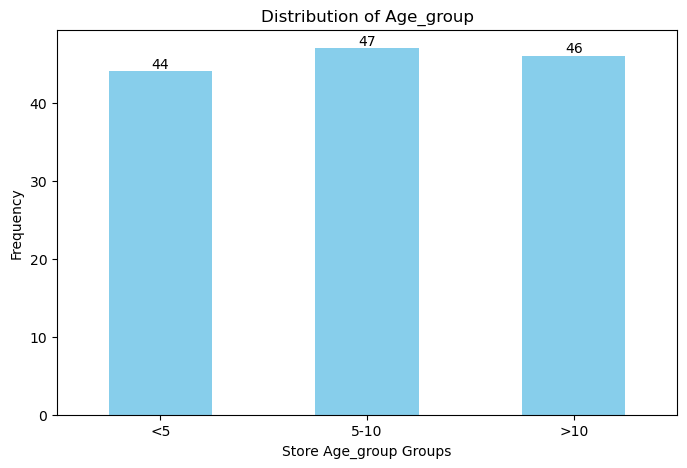

In [20]:
plot_bar_distribution(
    data,
    "Age_group",
    "LocationID",
    title="Distribution of Age_group",
    xlabel="Store Age_group Groups",
)

In order to achieve the most equal groups, the following was selected: less than 5 years, from 5 to 10 years and more than 10 years.

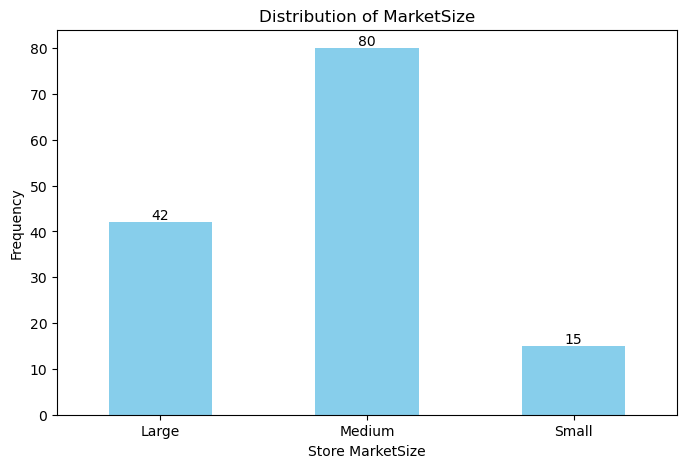

In [21]:
plot_bar_distribution(
    data,
    "MarketSize",
    "LocationID",
    title="Distribution of MarketSize",
    xlabel="Store MarketSize",
)

Great part of all store was Medium size - 80, medium - 42 and small only 15 stores. 

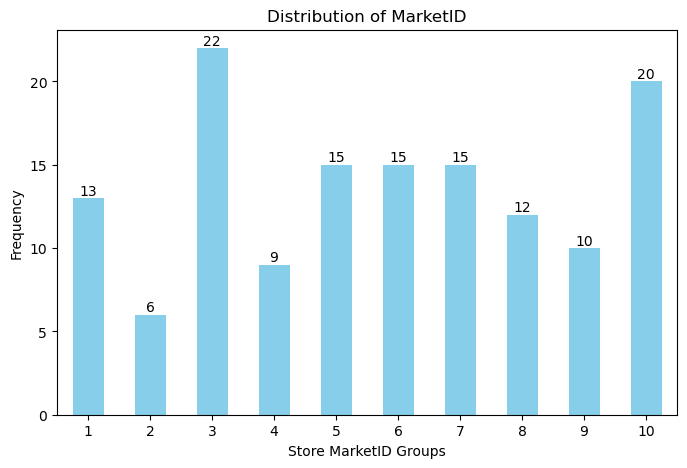

In [22]:
plot_bar_distribution(
    data,
    "MarketID",
    "LocationID",
    title="Distribution of MarketID",
    xlabel="Store MarketID Groups",
)

Distribution of MarkedID plot do not shows facts which could be used in analysis, for this reason it will not be used.

### Calculation sum of SalesInThousands for Promotions

In [23]:
sample_size = len(data)
print("Sample size:", sample_size)

Sample size: 548


In [24]:
promotion_proportion = data["Promotion"].value_counts(normalize=True)
print(promotion_proportion)

Promotion
3    0.343066
2    0.343066
1    0.313869
Name: proportion, dtype: float64


In [25]:
expected_proportions = [0.33, 0.33, 0.34]

observed_counts = data["Promotion"].value_counts().values

expected_counts = [sum(observed_counts) * p for p in expected_proportions]
chi2, p_value = stats.chisquare(observed_counts, expected_counts)

if p_value < 0.05:
    print("Sample Ratio Mismatch (SRM) found.")
else:
    print(
        "The proportions match expectations, no Sample Ratio Mismatch (SRM) detected."
    )

The proportions match expectations, no Sample Ratio Mismatch (SRM) detected.


In [26]:
filtered_data1 = data[data["Promotion"] == 1]
filtered_data2 = data[data["Promotion"] == 2]
filtered_data3 = data[data["Promotion"] == 3]

sum_sales1 = round(filtered_data1["SalesInThousands"].sum(), 2)
sum_sales2 = round(filtered_data2["SalesInThousands"].sum(), 2)
sum_sales3 = round(filtered_data3["SalesInThousands"].sum(), 2)

print(f"SalesInThousands sum, promotion = 1: {sum_sales1:.2f}")
print(f"SalesInThousands sum, promotion = 2: {sum_sales2:.2f}")
print(f"SalesInThousands sum, promotion = 3: {sum_sales3:.2f}")

SalesInThousands sum, promotion = 1: 9993.03
SalesInThousands sum, promotion = 2: 8897.93
SalesInThousands sum, promotion = 3: 10408.52


### Calculation of confindence intervals

In [27]:
group1 = data[data["Promotion"] == 1]["SalesInThousands"]
group2 = data[data["Promotion"] == 2]["SalesInThousands"]
group3 = data[data["Promotion"] == 3]["SalesInThousands"]

confidence = 0.95


def calculate_ci(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    t_critical = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin_of_error = t_critical * (std_dev / np.sqrt(n))
    return mean - margin_of_error, mean + margin_of_error


ci_group1 = calculate_ci(group1, confidence)
ci_group2 = calculate_ci(group2, confidence)
ci_group3 = calculate_ci(group3, confidence)

print(f"95% CI gruop 1: {ci_group1}")
print(f"95% CI gruop 2: {ci_group2}")
print(f"95% CI gruop 3: {ci_group3}")

95% CI gruop 1: (np.float64(55.607484514043875), np.float64(60.59053874177009))
95% CI gruop 2: (np.float64(45.15559592812869), np.float64(49.503233859105336))
95% CI gruop 3: (np.float64(52.95220655144981), np.float64(57.776729618762964))


### Calculating medians for SalesInThousands in all combinations of MarketSize, Promotion, week and age group.

In [28]:
market_sizes = data["MarketSize"].unique()
promotions = data["Promotion"].unique()
weeks = data["week"].unique()
age_groups = data["Age_group"].unique()
combinations = list(itertools.product(market_sizes, promotions, weeks, age_groups))

descriptions = {}
for market_size, promotion, week, age_group in combinations:
    group = data[
        (data["MarketSize"] == market_size)
        & (data["Promotion"] == promotion)
        & (data["week"] == week)
        & (data["Age_group"] == age_group)
    ]
    if not group.empty:
        descriptions[(market_size, promotion, week, age_group)] = group[
            "SalesInThousands"
        ].describe()
combined_describe = pd.concat(descriptions.values(), axis=1)

combined_describe.columns = [
    f"MS{key[0]}_P{key[1]}_W{key[2]}_AG{key[3]}" for key in descriptions.keys()
]
combined_describe
medians = combined_describe.loc["50%"]
medians

MSMedium_P3_W1_AG<5      47.630
MSMedium_P3_W1_AG5-10    45.560
MSMedium_P3_W1_AG>10     49.670
MSMedium_P3_W2_AG<5      49.720
MSMedium_P3_W2_AG5-10    46.290
                          ...  
MSLarge_P1_W3_AG5-10     79.455
MSLarge_P1_W3_AG>10      78.400
MSLarge_P1_W4_AG<5       66.970
MSLarge_P1_W4_AG5-10     87.360
MSLarge_P1_W4_AG>10      76.510
Name: 50%, Length: 104, dtype: float64

### Function for ploting differnet combination of store size, store age, promotion.

In [29]:
def filter_and_plot_multiple_grid(
    data, market_sizes, promotions, age_group, x_axis="week"
):
    rows = 1
    cols = len(market_sizes)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))
    axes = axes.flatten() if cols > 1 else [axes]

    for col, market_size in enumerate(market_sizes):
        for promotion in promotions:
            filtered = data.filter(like=f"{market_size}_{promotion}_")
            filtered = filtered[filtered.index.str.contains(age_group)]
            weeks = np.array([idx.split("_")[2] for idx in filtered.index])
            values = filtered.values.flatten()

            if x_axis == "week":
                axes[col].plot(weeks, values, marker="o", label=f"{promotion}")

                for i, value in enumerate(values):
                    offset = 12 if i % 2 == 0 else -15
                    axes[col].annotate(
                        f"{value:.1f}",
                        (weeks[i], values[i]),
                        textcoords="offset points",
                        xytext=(offset, 0),
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
                    )
            else:
                x_labels = [
                    idx.split("_")[
                        {"market_size": 0, "promotion": 1, "age_group": 3}[x_axis]
                    ]
                    for idx in filtered.index
                ]
                axes[col].plot(x_labels, values, marker="o", label=f"{promotion}")

                for i, value in enumerate(values):
                    offset = 12 if i % 2 == 0 else -15
                    axes[col].annotate(
                        f"{value:.1f}",
                        (x_labels[i], values[i]),
                        textcoords="offset points",
                        xytext=(offset, 0),
                        ha="center",
                        va="center",
                        fontsize=9,
                        color="black",
                        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
                    )

        axes[col].set_title(f"{market_size} - {age_group}")
        axes[col].set_xlabel(
            "Week" if x_axis == "week" else x_axis.replace("_", " ").capitalize()
        )
        axes[col].set_ylabel("Value")
        axes[col].legend()
        axes[col].grid(True)

    for ax in axes:
        ax.set_ylim(30, 95)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

### Printing plots

MSSmall - Small size market
MSMedium - Medium size market,
MSLarge - Large size market,
AG<5 - Store age <5 years,
AG5-10 - Store age 5-10 years, 
AG>10 - Store age >10 years, 


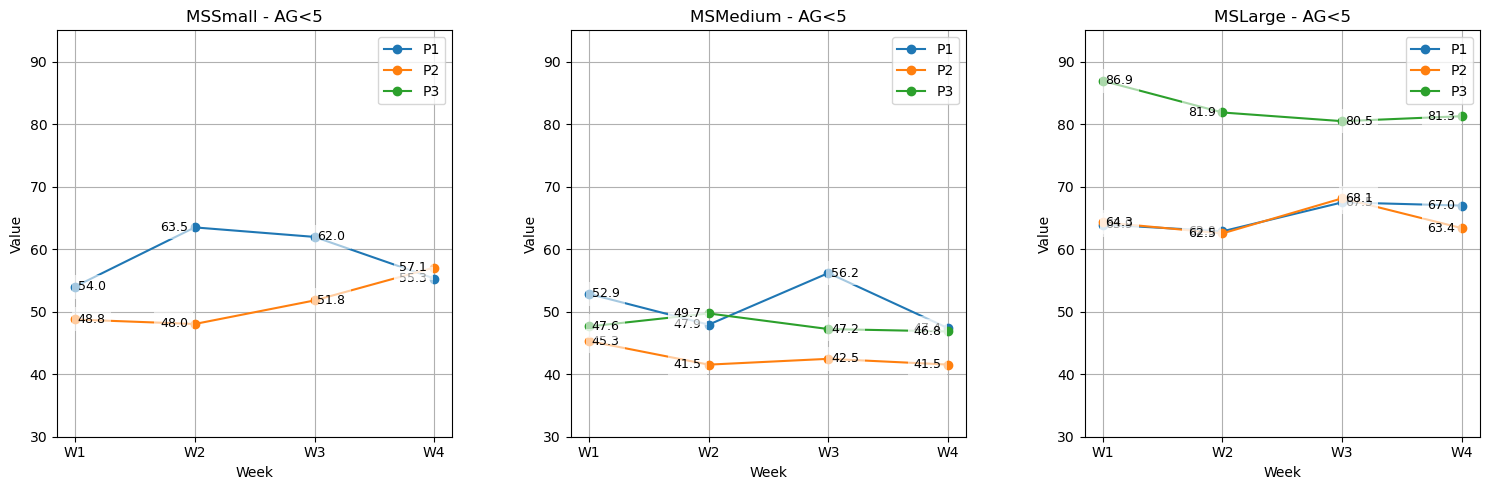

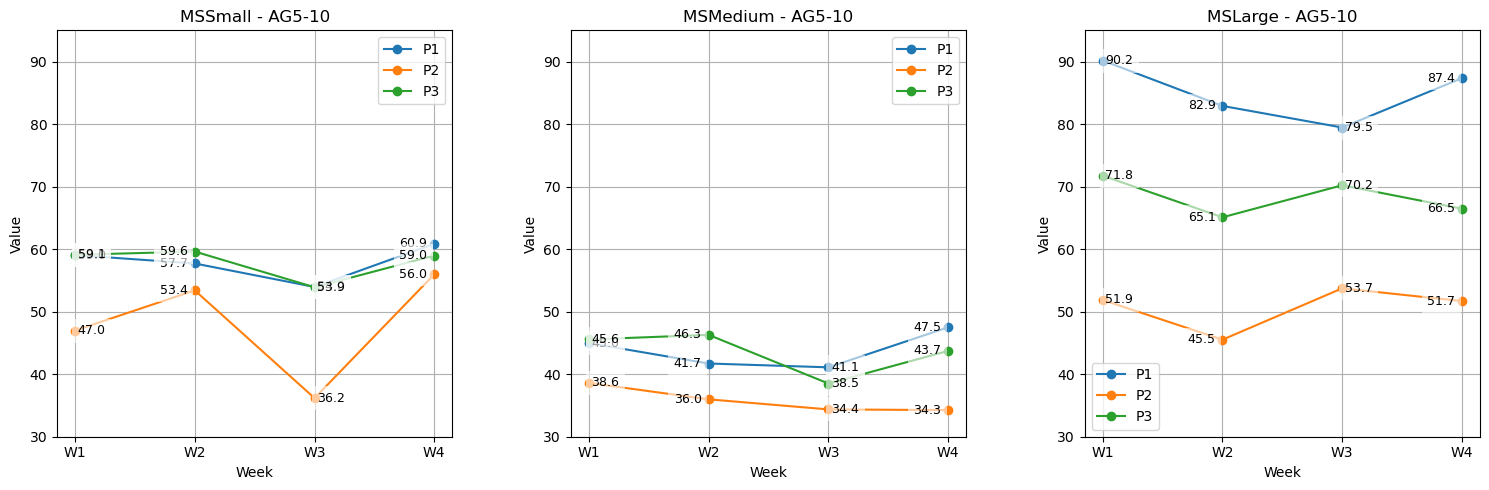

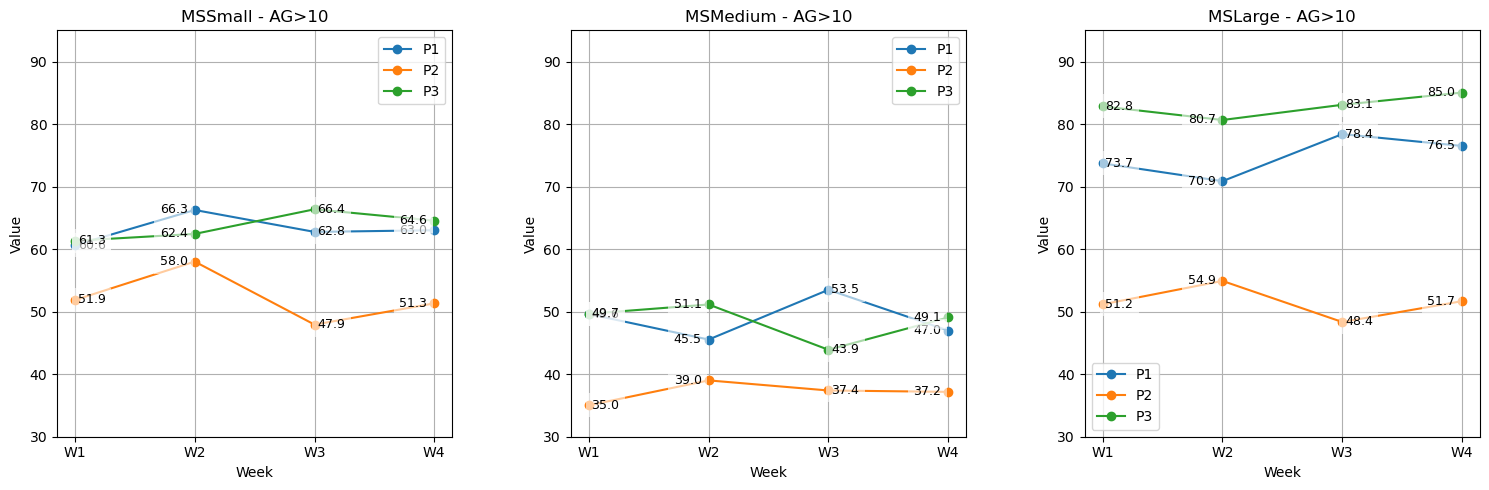

In [30]:
print(
    "MSSmall - Small size market\nMSMedium - Medium size market,\nMSLarge - Large size market,\nAG<5 - Store age <5 years,\nAG5-10 - Store age 5-10 years, \nAG>10 - Store age >10 years, "
)
filter_and_plot_multiple_grid(
    medians,
    market_sizes=["MSSmall", "MSMedium", "MSLarge"],
    promotions=["P1", "P2", "P3"],
    age_group="AG<5",
    x_axis="week",
)
filter_and_plot_multiple_grid(
    medians,
    market_sizes=["MSSmall", "MSMedium", "MSLarge"],
    promotions=["P1", "P2", "P3"],
    age_group="AG5-10",
    x_axis="week",
)
filter_and_plot_multiple_grid(
    medians,
    market_sizes=["MSSmall", "MSMedium", "MSLarge"],
    promotions=["P1", "P2", "P3"],
    age_group="AG>10",
    x_axis="week",
)

Small, Age_group: <5 - Promotion 1 performing better in first week, but following weeks decreases. Promotion 2 performence was increasing. Promotion 3 was not applied.
Medium, Age_group: <5 - Promotion 1 has a small increase in 3rd week, but generally stays in in similar level. Promotion 2 and Promotion 3 stays stable during all period.
Large, Age_group: <5 - Promotion 1 - with a slight positive change, Promotion 2 - without much change, Promotion 3 - first week with highest sales, second weeks sligly drops and stays stable.
Small, Age_group: 5-10 - Promotion 1 and Promotion 3 stays close and stable, Promotion 2 has drop in 3rd week.


In [31]:
unique_market_sizes = data["MarketSize"].unique()
unique_age_groups = data["Age_group"].unique()

print("Combinations of: MarketSize Age_group with LocationID:")

for market_size in unique_market_sizes:
    for age_group in unique_age_groups:
        filtered_data = data[
            (data["MarketSize"] == market_size) & (data["Age_group"] == age_group)
        ]

        unique_location_count = filtered_data["LocationID"].nunique()

        print(
            f"MarketSize: {market_size}, Age_group: {age_group} -> Uniq LocationID: {unique_location_count}"
        )

Combinations of: MarketSize Age_group with LocationID:
MarketSize: Medium, Age_group: <5 -> Uniq LocationID: 23
MarketSize: Medium, Age_group: 5-10 -> Uniq LocationID: 28
MarketSize: Medium, Age_group: >10 -> Uniq LocationID: 29
MarketSize: Small, Age_group: <5 -> Uniq LocationID: 3
MarketSize: Small, Age_group: 5-10 -> Uniq LocationID: 7
MarketSize: Small, Age_group: >10 -> Uniq LocationID: 5
MarketSize: Large, Age_group: <5 -> Uniq LocationID: 18
MarketSize: Large, Age_group: 5-10 -> Uniq LocationID: 12
MarketSize: Large, Age_group: >10 -> Uniq LocationID: 12


### Creating new data table

In [32]:
data_cut = data

data_cut.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,Age_group
0,1,Medium,1,4,3,1,33.73,<5
1,1,Medium,1,4,3,2,35.67,<5
2,1,Medium,1,4,3,3,29.03,<5
3,1,Medium,1,4,3,4,39.25,<5
4,1,Medium,2,5,2,1,27.81,5-10


## Analysis

### Shapiro-Wilk test

In [33]:
for size in data_cut["Promotion"].unique():
    sales = data_cut[data_cut["Promotion"] == size]["SalesInThousands"]
    stat, p_value = shapiro(sales)
    print(
        f"Promotion: {size}\n  Shapiro-Wilk Statistic: {stat}\n  p-value: {p_value}\n  Result: {'Data is not normally distributed.' if p_value < 0.05 else 'Data is normally distributed.'}"
    )

Promotion: 3
  Shapiro-Wilk Statistic: 0.9207683041490243
  p-value: 1.49946592611918e-08
  Result: Data is not normally distributed.
Promotion: 2
  Shapiro-Wilk Statistic: 0.914509809064016
  p-value: 5.457099666274281e-09
  Result: Data is not normally distributed.
Promotion: 1
  Shapiro-Wilk Statistic: 0.9152999060992891
  p-value: 1.9772645044477294e-08
  Result: Data is not normally distributed.


Test show that all Promotions are distributed not normally.

### Comparison of Promotion using Mann-Whitney U test.

In [34]:
sales_promo1 = data_cut[data_cut["Promotion"] == 1]["SalesInThousands"]
sales_promo2 = data_cut[data_cut["Promotion"] == 2]["SalesInThousands"]
sales_promo3 = data_cut[data_cut["Promotion"] == 3]["SalesInThousands"]

if len(sales_promo1) > 1 and len(sales_promo2) > 1 and len(sales_promo3) > 1:
    stat, p_value = kruskal(sales_promo1, sales_promo2, sales_promo3)

    print(
        f"Comparison of Promotion 1, Promotion 2 and Promotion 3 (across all Market Sizes)"
    )
    print(f"  Median Promotion 1: {sales_promo1.median():.2f}")
    print(f"  Median Promotion 2: {sales_promo2.median():.2f}")
    print(f"  Median Promotion 3: {sales_promo3.median():.2f}")
    print(f"  Kruskal-Wallis p-value: {p_value:.4f}")

    if p_value < 0.05:
        print(
            "  Significant difference found. Performing pairwise Mann-Whitney U tests with Bonferroni correction:"
        )

        comparisons = [
            ("Promotion 1 vs Promotion 2", sales_promo1, sales_promo2),
            ("Promotion 1 vs Promotion 3", sales_promo1, sales_promo3),
            ("Promotion 2 vs Promotion 3", sales_promo2, sales_promo3),
        ]

        for name, group1, group2 in comparisons:
            u_stat, pairwise_p = mannwhitneyu(group1, group2)
            corrected_p = pairwise_p * 3
            corrected_p = min(corrected_p, 1.0)

            print(f"  {name}: Mann-Whitney U p-value (corrected): {corrected_p:.4f}")
            print(
                f"    {'Significant difference' if corrected_p < 0.05 else 'No significant difference'}"
            )

    else:
        print("  No significant difference found among the three promotions.")

Comparison of Promotion 1, Promotion 2 and Promotion 3 (across all Market Sizes)
  Median Promotion 1: 55.39
  Median Promotion 2: 45.39
  Median Promotion 3: 51.16
  Kruskal-Wallis p-value: 0.0000
  Significant difference found. Performing pairwise Mann-Whitney U tests with Bonferroni correction:
  Promotion 1 vs Promotion 2: Mann-Whitney U p-value (corrected): 0.0000
    Significant difference
  Promotion 1 vs Promotion 3: Mann-Whitney U p-value (corrected): 0.1053
    No significant difference
  Promotion 2 vs Promotion 3: Mann-Whitney U p-value (corrected): 0.0000
    Significant difference


Regarding to plots and Mann-Whitney U tests Promotion 2 is removed from comparison. Promotion 2 is significantly different and lower performance.

### Promotion 1 and promotion 3 checking for significant differences using Mann-Whitney U test.


In [35]:
sales_promo1 = data_cut[data_cut["Promotion"] == 1]["SalesInThousands"]

sales_promo3 = data_cut[data_cut["Promotion"] == 3]["SalesInThousands"]

if len(sales_promo1) > 1 and len(sales_promo2) > 1 and len(sales_promo3) > 1:
    stat, p_value = mannwhitneyu(sales_promo1, sales_promo3)
    print(f"Comparison of Promotion 1, Promotion 3 (across all Market Sizes)")
    print(f"  Median Promotion 1: {sales_promo1.median():.2f}")

    print(f"  Median Promotion 3: {sales_promo3.median():.2f}")
    print(f"  Mann-Whitney U p-value: {p_value:.4f}")
    print(
        f"  {'Significant difference' if p_value < 0.05 else 'No significant difference'}\n"
    )

Comparison of Promotion 1, Promotion 3 (across all Market Sizes)
  Median Promotion 1: 55.39
  Median Promotion 3: 51.16
  Mann-Whitney U p-value: 0.0351
  Significant difference



Promotion 1 and Promotion 2 has Significant difference.

### Comparing Promotion 1 and Promotion 2, which performs better.

In [36]:
mean_promo1 = sales_promo1.mean()
mean_promo3 = sales_promo3.mean()

median_promo1 = sales_promo1.median()
median_promo3 = sales_promo3.median()

print(f"Promotion 1 - Mean: {mean_promo1:.2f}, Median: {median_promo1:.2f}")
print(f"Promotion 3 - Mean: {mean_promo3:.2f}, Median: {median_promo3:.2f}")

if median_promo1 > median_promo3:
    print("Promotion 1 is better based on median sales.")
else:
    print("Promotion 3 is better based on median sales.")


if mean_promo1 > mean_promo3:
    print("Promotion 1 is better based on mean sales.")
else:
    print("Promotion 3 is better based on mean sales.")

Promotion 1 - Mean: 58.10, Median: 55.39
Promotion 3 - Mean: 55.36, Median: 51.16
Promotion 1 is better based on median sales.
Promotion 1 is better based on mean sales.


### Promotion 1 is the best performing promotion.

## Promotions results spread by size

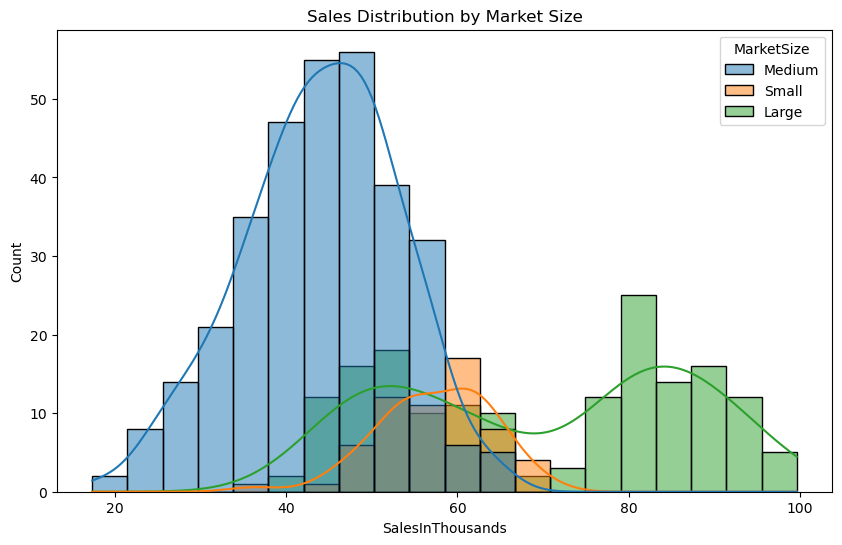

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data_cut, x="SalesInThousands", hue="MarketSize", kde=True, bins=20)
plt.title("Sales Distribution by Market Size")
plt.show()

 Diagram shows that medium size Stores spread widest. 

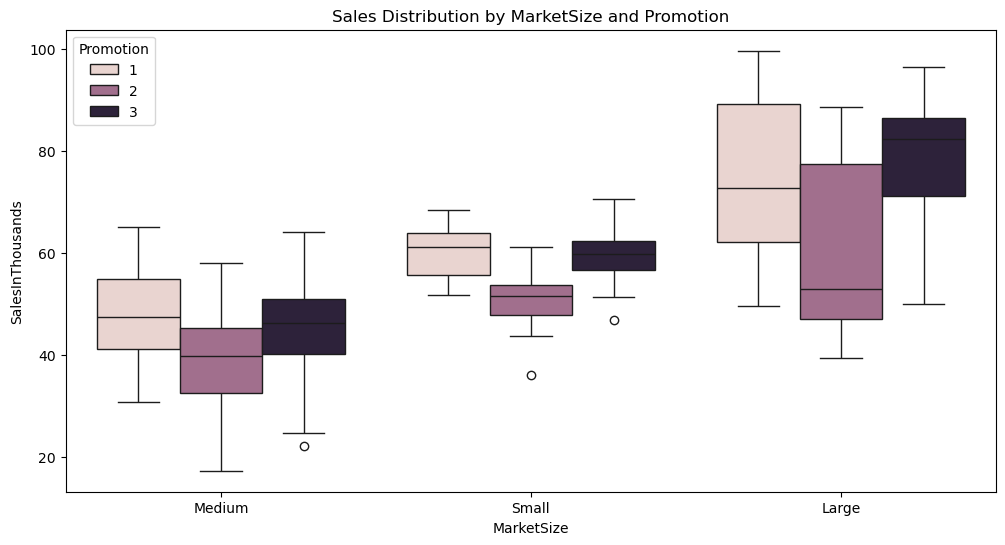

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_cut, x="MarketSize", y="SalesInThousands", hue="Promotion")
plt.title("Sales Distribution by MarketSize and Promotion")
plt.show()

Small market - Promotion 1 and Promotion 3 is in same level, Promotion 2 is behind.
Medium market - more stable than in large market.
Large market - Promotion 1 generates highest sales median, Promotion 2 has the highest dispersion, Promotion 3 - stable with high median.


In [39]:
sales_summary = data_cut.groupby(["MarketSize", "Promotion"])["SalesInThousands"].agg(
    ["mean", "std", "median"]
)
print(sales_summary)

                           mean        std  median
MarketSize Promotion                              
Large      1          75.235893  15.497497  72.835
           2          60.322031  15.728529  53.010
           3          77.203958  14.400304  82.345
Medium     1          47.672604   8.067331  47.425
           2          39.114352   8.807407  39.765
           3          45.468879   8.091366  46.295
Small      1          60.162500   5.127279  61.145
           2          50.810625   5.869816  51.600
           3          59.514167   5.212687  59.745


Highest mean and median has Promotion 3 in large market, lowest - Promotion 2 in medium market. 
Highest Standart deviation - Promotion 1 in large market, lowest - Promotion 1 in small market.

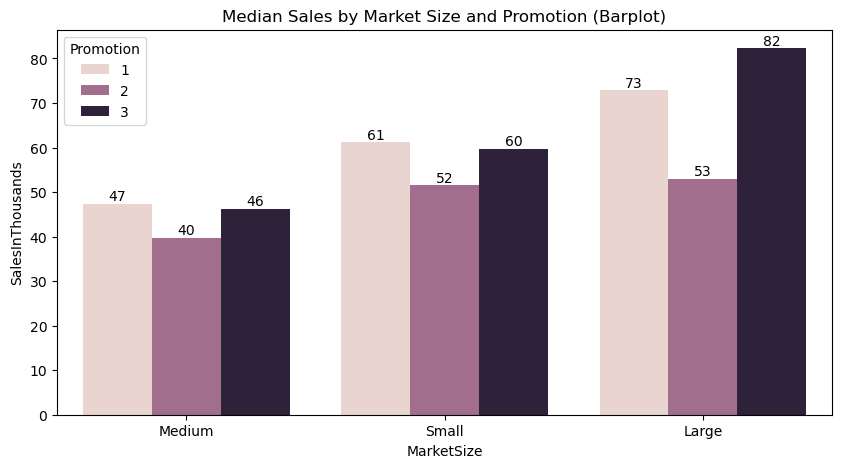

In [40]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=data_cut,
    x="MarketSize",
    y="SalesInThousands",
    hue="Promotion",
    estimator=lambda x: x.median(),
    errorbar=None,
)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(
            f"{height:.0f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            fontsize=10,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

plt.title("Median Sales by Market Size and Promotion (Barplot)")
plt.show()

Diagram shows that Promotion 2 is least sales performing. The least performing ad is not analyzed further.

### Mann-Whitney U test

In [41]:
for market_size in data_cut["MarketSize"].unique():
    sales_promo1 = data_cut[
        (data_cut["MarketSize"] == market_size) & (data_cut["Promotion"] == 1)
    ]["SalesInThousands"]
    sales_promo3 = data_cut[
        (data_cut["MarketSize"] == market_size) & (data_cut["Promotion"] == 3)
    ]["SalesInThousands"]

    if len(sales_promo1) > 1 and len(sales_promo3) > 1:
        stat, p_value = mannwhitneyu(sales_promo1, sales_promo3)
        print(f"Market Size: {market_size}")
        print(f"  Median Promotion 1: {sales_promo1.median():.2f}")
        print(f"  Median Promotion 3: {sales_promo3.median():.2f}")
        print(f"  Mann-Whitney U p-value: {p_value:.4f}")
        print(
            f"  {'Significant difference' if p_value < 0.05 else 'No significant difference'}\n"
        )

Market Size: Medium
  Median Promotion 1: 47.42
  Median Promotion 3: 46.30
  Mann-Whitney U p-value: 0.1056
  No significant difference

Market Size: Small
  Median Promotion 1: 61.14
  Median Promotion 3: 59.74
  Mann-Whitney U p-value: 0.7954
  No significant difference

Market Size: Large
  Median Promotion 1: 72.84
  Median Promotion 3: 82.34
  Mann-Whitney U p-value: 0.9766
  No significant difference



There are no significant difference between MarketSizes.


Promotion 1 and promotion 2 sales medians by market size.

In [42]:
df_promo = data_cut[data_cut["Promotion"].isin([1, 3])]

grouped_median = (
    df_promo.groupby(["MarketSize", "Promotion"])["SalesInThousands"].median().unstack()
)
print(grouped_median)

Promotion        1       3
MarketSize                
Large       72.835  82.345
Medium      47.425  46.295
Small       61.145  59.745


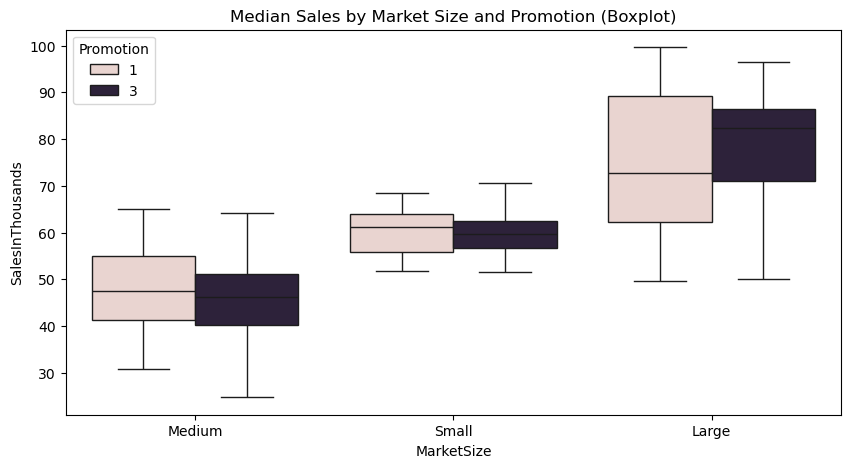

In [43]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_promo,
    x="MarketSize",
    y="SalesInThousands",
    hue="Promotion",
    showfliers=False,
)
plt.title("Median Sales by Market Size and Promotion (Boxplot)")
plt.show()

In [44]:
df_promo = data_cut[data_cut["Promotion"].isin([1, 3])]

grouped = (
    df_promo.groupby(["MarketSize", "Age_group", "Promotion"])["SalesInThousands"]
    .mean()
    .unstack()
)

print(grouped)

Promotion                     1          3
MarketSize Age_group                      
Large      <5         73.233125  80.360833
           5-10       79.421250  68.382500
           >10        74.876250  76.879375
Medium     <5         50.042857  45.944500
           5-10       45.245000  43.335192
           >10        47.712750  47.774318
Small      <5         58.687500        NaN
           5-10       57.891250  57.431875
           >10        63.171250  63.678750


C:\Users\Dell\AppData\Local\Temp\ipykernel_19132\3636846581.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_promo.groupby(["MarketSize", "Age_group", "Promotion"])["SalesInThousands"]


c:\Users\Dell\anaconda3\envs\pydata-book\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Dell\anaconda3\envs\pydata-book\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Dell\anaconda3\envs\pydata-book\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


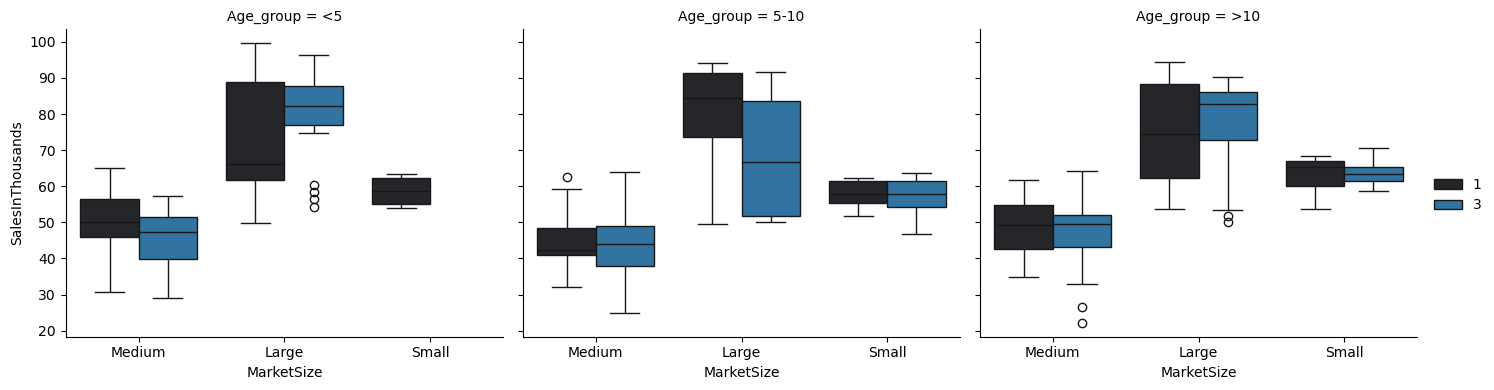

In [45]:
g = sns.FacetGrid(df_promo, col="Age_group", height=4, aspect=1.2)
g.map_dataframe(sns.boxplot, x="MarketSize", y="SalesInThousands", hue="Promotion")
g.add_legend()
plt.show()

In [46]:
for market_size in data_cut["MarketSize"].unique():
    for age_group in data_cut["Age_group"].unique():
        sales_promo1 = df_promo[
            (df_promo["MarketSize"] == market_size)
            & (df_promo["Age_group"] == age_group)
            & (df_promo["Promotion"] == 1)
        ]["SalesInThousands"]
        sales_promo3 = df_promo[
            (df_promo["MarketSize"] == market_size)
            & (df_promo["Age_group"] == age_group)
            & (df_promo["Promotion"] == 3)
        ]["SalesInThousands"]

        if len(sales_promo1) > 1 and len(sales_promo3) > 1:
            stat, p_value = mannwhitneyu(sales_promo1, sales_promo3)
            print(f"MarketSize: {market_size}, Age Group: {age_group}")
            print(f"  Mann-Whitney U p-value: {p_value}")
            print(
                f"  {'Significant difference' if p_value < 0.05 else 'No significant difference'}\n"
            )

MarketSize: Medium, Age Group: <5
  Mann-Whitney U p-value: 0.1242726598368692
  No significant difference

MarketSize: Medium, Age Group: 5-10
  Mann-Whitney U p-value: 0.5894285095692647
  No significant difference

MarketSize: Medium, Age Group: >10
  Mann-Whitney U p-value: 0.9892812761230612
  No significant difference

MarketSize: Small, Age Group: 5-10
  Mann-Whitney U p-value: 0.976103748482265
  No significant difference

MarketSize: Small, Age Group: >10
  Mann-Whitney U p-value: 0.7984459984459983
  No significant difference

MarketSize: Large, Age Group: <5
  Mann-Whitney U p-value: 0.21740018026370755
  No significant difference

MarketSize: Large, Age Group: 5-10
  Mann-Whitney U p-value: 0.19235564692557555
  No significant difference

MarketSize: Large, Age Group: >10
  Mann-Whitney U p-value: 0.8809755925114653
  No significant difference



##### There are no significant difference when divided to smaller groups.

### Shapiro test for stores by Market size 

In [47]:
for size in data["MarketSize"].unique():
    sales = data[data["MarketSize"] == size]["SalesInThousands"]
    stat, p_value = shapiro(sales)
    print(
        f"Market Size: {size}\n  Shapiro-Wilk Statistic: {stat}\n  p-value: {p_value}\n  Result: {'Data is not normally distributed.' if p_value < 0.05 else 'Data is normally distributed.'}"
    )

Market Size: Medium
  Shapiro-Wilk Statistic: 0.9926635583222764
  p-value: 0.11771711462038886
  Result: Data is normally distributed.
Market Size: Small
  Shapiro-Wilk Statistic: 0.9777515771136023
  p-value: 0.3409968642085152
  Result: Data is normally distributed.
Market Size: Large
  Shapiro-Wilk Statistic: 0.9209786258468111
  p-value: 6.40176396159093e-08
  Result: Data is not normally distributed.


### Shapiro-Wilk test for all combinations of Market Size and Age group.

In [48]:
market_counts = data_cut["MarketSize"].value_counts()
market_proportion = market_counts / market_counts.sum()
print(market_proportion)

MarketSize
Medium    0.583942
Large     0.306569
Small     0.109489
Name: count, dtype: float64


In [49]:
market_counts = data_cut.groupby("Age_group")["MarketSize"].value_counts(normalize=True)
print(market_counts)

Age_group  MarketSize
<5         Medium        0.522727
           Large         0.409091
           Small         0.068182
5-10       Medium        0.595745
           Large         0.255319
           Small         0.148936
>10        Medium        0.630435
           Large         0.260870
           Small         0.108696
Name: proportion, dtype: float64


C:\Users\Dell\AppData\Local\Temp\ipykernel_19132\3232440492.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  market_counts = data_cut.groupby("Age_group")["MarketSize"].value_counts(normalize=True)


In [50]:
def clean_age_group(age):
    return age.strip().replace(" ", "").replace("<", "<").replace(">", ">")


data_cut["Age_group"] = data_cut["Age_group"].astype(str).apply(clean_age_group)

age_groups_ordered = ["<5", "5-10", ">10"]
market_sizes = data_cut["MarketSize"].unique()

for size, age in product(market_sizes, age_groups_ordered):

    sales = data_cut[(data_cut["MarketSize"] == size) & (data_cut["Age_group"] == age)][
        "SalesInThousands"
    ]

    if len(sales) < 3:
        print(
            f"Market Size: {size}, Age Group: {age} - Too few data points for the Shapiro-Wilk test."
        )
        continue
    try:
        stat, p_value = shapiro(sales)
        result = (
            "Data is not normally distributed."
            if p_value < 0.05
            else "Data is normally distributed."
        )
        print(f"\nMarket Size: {size}, Age Group: {age}")
        print(f"Shapiro-Wilk Statistic: {stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Result: {result}")

    except Exception as e:
        print(f"Error in analysis '{size}' & '{age}': {e}")


Market Size: Medium, Age Group: <5
Shapiro-Wilk Statistic: 0.9913
p-value: 0.8090
Result: Data is normally distributed.

Market Size: Medium, Age Group: 5-10
Shapiro-Wilk Statistic: 0.9953
p-value: 0.9698
Result: Data is normally distributed.

Market Size: Medium, Age Group: >10
Shapiro-Wilk Statistic: 0.9690
p-value: 0.0086
Result: Data is not normally distributed.

Market Size: Small, Age Group: <5
Shapiro-Wilk Statistic: 0.9546
p-value: 0.7043
Result: Data is normally distributed.

Market Size: Small, Age Group: 5-10
Shapiro-Wilk Statistic: 0.8759
p-value: 0.0033
Result: Data is not normally distributed.

Market Size: Small, Age Group: >10
Shapiro-Wilk Statistic: 0.9487
p-value: 0.3481
Result: Data is normally distributed.

Market Size: Large, Age Group: <5
Shapiro-Wilk Statistic: 0.9510
p-value: 0.0071
Result: Data is not normally distributed.

Market Size: Large, Age Group: 5-10
Shapiro-Wilk Statistic: 0.8728
p-value: 0.0001
Result: Data is not normally distributed.

Market Size:

# Results 


This analysis represents that the best performing promotion - Promotion 1.

## Improves for the future

- Could be analized all promotions dinamic by weeks. 
- Could be analized Promotions efficence in different variations of market Size and Age, but for this more data needed.